# Radial Basis Function Networks
In this Notebook we will implement and test a simple RBFN. As always, we will start by defining the model class. To create a RBFN, we need to store the following parameters:
* Centers and spread of the Radial Basis Functions $\mathbf{t} \in \mathbb{R}^{(h \times i)}$, $\sigma \in \mathbb{R}$
* Weights between the hidden layer and the output layer $W \in \mathbb{R}^{(o \times h)}$

(where $o, i$ and $h$ are respectively the number of *input* units, *output* units and the number of *hidden* units)

We also define $\varphi$ (which is the RBF that will be used by the hidden units) as the *Gaussian*.

In [171]:
import numpy as np
import matplotlib.pyplot as plt 

def gaussian(d, sigma):
    return np.exp(-d**2/(2*sigma)**2)

# Model class
class RBFN:
    # We must define the number of input units, the number of hidden units and the number of output units
    def __init__(self, h):
        self.h = h
        self.trained = False

    # Given a training set, determine the centers of the RBFs by mans of clustering
    def initialize_centers(self, X, eta = 0.1, epochs = 100):
        # Assign the centers randomly
        self.t = np.random.rand(self.h, X.shape[1])
        # An epoch defines an entire run of the dataset
        for e in range(epochs):
            for x_i in X:
                # Get the closest center to x_i
                dist = np.linalg.norm(x_i - self.t, axis=-1) 
                cmin = np.argmin(dist)
                # Apply the correction
                if(dist[cmin] != 0): self.t[cmin] += eta * (x_i - self.t[cmin])

    # Initialize Sigma by normalization
    def initialize_sigma(self):
        # Compute pairwise distances, then take the maximum
        p_dists = np.linalg.norm(self.t[None, :] - self.t[:, None], axis =-1)
        d_max = np.max(p_dists)
        # initialize sigma
        self.sigma = d_max**2 / np.sqrt(self.h)

    # Training the network involves 3 main steps:
    # * Initialize centers by means of clustering
    # * Initialize sigma
    # * Compute the weights with the pseudoinverse method
    def train(self, X, y):
        self.initialize_centers(X)
        self.initialize_sigma()
        # Compute PHI
        phi = gaussian(np.linalg.norm(X[:, None] - self.t[None, :], axis = -1), self.sigma)
        # Now we can obtain the weights by pseudoinverse
        self.w = np.linalg.pinv(phi) @ y
        self.trained = True
    
    def predict(self, X):
        if(self.trained is not True): print("An unlearned model cannot predict")
        phi = gaussian(np.linalg.norm(X[:, None] - self.t[None, :], axis = -1), self.sigma)
        return phi @ self.w

Let's now test the model with a non-linearly separable problem: The concentric problem. 
Ideally, our trained network will be able to separate the two classes.

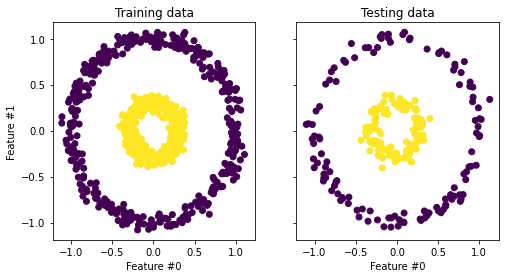

In [177]:
# Taken from https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html#sphx-glr-auto-examples-decomposition-plot-kernel-pca-py
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

MSE of the model is 0.051758420359733874


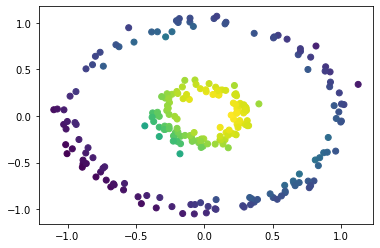

In [178]:
# You can fine tune and play with the number of hidden layers
rbfn = RBFN(2)
rbfn.train(X_train, y_train)
y_predicted = rbfn.predict(X_test)

plt.scatter(X_test[:,0], X_test[:, 1], c = y_predicted)

mse = np.sum((y_test - y_predicted)**2) / len(y_test) 
print(f"MSE of the model is {mse}")

The MSE lowers as the number of hidden units increases. That is reasonable, since a linear combination of Gaussians can approximate any function.